In [1]:
import sys
sys.path.insert(0, '../')

# sys.path.remove("/home/users/yixiuz/.local/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/bin")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from tqdm import trange
import matplotlib.pyplot as plt

# Hollow transformers architecture

Two attention streams, padded and offset, mixed at the end.

In [299]:
class DirectionalTransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, direction='forward'):
        super(DirectionalTransformerBlock, self).__init__()
        self.direction = direction
        self.attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask=None):
        sz = query.size(0)
        device = query.device
        
        if self.direction == 'forward':
            mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1).to(device)
        elif self.direction == 'backward':
            mask = torch.tril(torch.ones(sz, sz) * float('-inf'), diagonal=-1).to(device)
        elif self.direction == 'mixed':
            # concatenate both the forward mask and the backward mask
            # this time mask out the diagonals
            forward_mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=0).to(device)
            backward_mask = torch.tril(torch.ones(sz, sz) * float('-inf'), diagonal=0).to(device)
            mask = torch.cat([forward_mask, backward_mask], dim=1)
        else:
            return None

        attention = self.attention(query, key, value, attn_mask=mask)[0]
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        
        # Probably also add a residual connection for the mixed case?
        
        return out
    
class HollowTransformer(nn.Module):
    def __init__(self, embed_size, heads, depth, dropout, forward_expansion, offset=True):
        """
        offset decides if the inputs in the two streams are offsetted 
        and therefore each output position doesn't gain information about the corresponding input position.
        """
        super(HollowTransformer, self).__init__()
        self.offset = offset
        self.forward_layers = nn.ModuleList([
            DirectionalTransformerBlock(embed_size, heads, dropout, forward_expansion, direction='forward')
            for _ in range(depth)
        ])
        self.backward_layers = nn.ModuleList([
            DirectionalTransformerBlock(embed_size, heads, dropout, forward_expansion, direction='backward')
            for _ in range(depth)
        ])

        # Optional: Final layer to combine the outputs
        self.output_layer = nn.Linear(embed_size, embed_size)  # Adjust depending on how you choose to combine

    def forward(self, x):
        zero_pad = torch.zeros(1, x.size(1), x.size(2)).to(x.device)
        if self.offset:
            forward_output = torch.cat([zero_pad, x[:-1]], dim=0)
            backward_output = torch.cat([x[1:], zero_pad], dim=0)
        else:
            forward_output = x
            backward_output = x

        # Process through all forward layers
        for layer in self.forward_layers:
            forward_output = layer(forward_output, forward_output, forward_output)

        # Process through all backward layers
        for layer in self.backward_layers:
            backward_output = layer(backward_output, backward_output, backward_output)

        # Combine the outputs from the two directions
        combined_output = forward_output + backward_output  # Example: simple addition

        # Optional: pass through the final output layer
        out = self.output_layer(combined_output)

        return out

# Model instantiation and example usage
# model = HollowTransformer(embed_size=256, heads=8, depth=6, dropout=0.1, forward_expansion=4)
# input_tensor = torch.randn(10, 1, 256)  # Example input [seq_length, batch_size, embed_size]
# output = model(input_tensor)

In [280]:
embed_size = 5
heads = 1
dropout = 0.1
forward_expansion = 2
seq_length = 10
batch_size = 100

learning_rate = 1e-3
num_epochs = 10000

forward_block = DirectionalTransformerBlock(embed_size, heads, dropout, forward_expansion, direction='forward')
backward_block = DirectionalTransformerBlock(embed_size, heads, dropout, forward_expansion, direction='backward')

# Example tensor
input_seq = torch.randn((seq_length, batch_size, embed_size))  # Adjust dimensions as needed
target_seq = input_seq

# Forward and backward passes
forward_output = forward_block(input_seq, input_seq, input_seq)
backward_output = backward_block(input_seq, input_seq, input_seq)

# Combine outputs
combined_output = forward_output + backward_output  # or other combination method

In [282]:
input_seq.dtype

torch.float32

In [149]:
# class HollowTransformer(nn.Module):
#     def __init__(self, embed_size, heads, dropout, forward_expansion):
#         super(HollowTransformer, self).__init__()
#         self.forward_block = DirectionalTransformerBlock(embed_size, heads, dropout, forward_expansion, direction='forward')
#         self.backward_block = DirectionalTransformerBlock(embed_size, heads, dropout, forward_expansion, direction='backward')

#     def forward(self, x):
#         forward_output = self.forward_block(x, x, x)
#         backward_output = self.backward_block(x, x, x)
#         output = forward_output + backward_output  # This is one way to combine them
#         return output

In [153]:
model = HollowTransformer(depth=3,
                          embed_size=embed_size, heads=heads, 
                          dropout=dropout, forward_expansion=forward_expansion,
                          offset=True)
params = model.parameters()
criterion = torch.nn.MSELoss()  # Adjust based on data type
optimizer = torch.optim.Adam(params, lr=learning_rate)  # Define your params and learning rate

losses = []

pbar = trange(num_epochs)
# Training loop
for epoch in pbar:
    optimizer.zero_grad()
    output = model(input_seq)
    loss = criterion(output, target_seq)
    loss.backward()
    losses.append(loss.detach())
    pbar.set_description("Loss:{:.4f}".format(loss.detach().numpy()))
    optimizer.step()


Loss:0.9916: 100%|██████████| 10000/10000 [03:12<00:00, 52.07it/s]


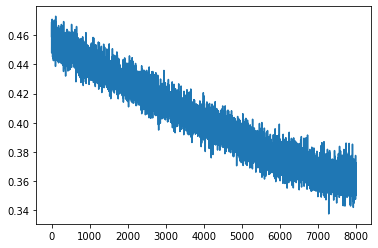

In [152]:
import matplotlib.pyplot as plt

plt.plot(losses[2000:])

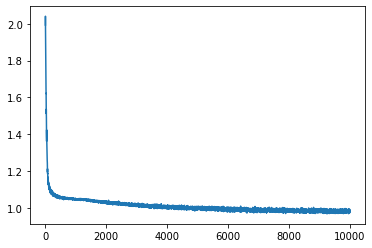

In [154]:
plt.plot(losses)

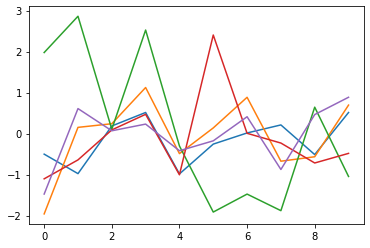

In [141]:
model.eval()

with torch.no_grad():
    out_seq = model(input_seq)
    
id = 3
plt.plot((input_seq-out_seq).numpy()[:,id])

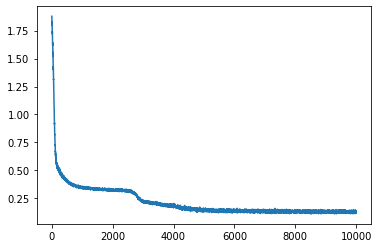

In [59]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [110]:
torch.tril(torch.ones(5, 6) * float('-inf'), diagonal=0)

tensor([[-inf, 0., 0., 0., 0., 0.],
        [-inf, -inf, 0., 0., 0., 0.],
        [-inf, -inf, -inf, 0., 0., 0.],
        [-inf, -inf, -inf, -inf, 0., 0.],
        [-inf, -inf, -inf, -inf, -inf, 0.]])

In [112]:
torch.triu(torch.ones(5, 6) * float('-inf'), diagonal=1)

tensor([[0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., -inf]])

# Bi-XLNet architecture

2 content streams, 1 query stream. Information is mixed at every level.

In [367]:
class BiXLNet(nn.Module):
    def __init__(self, seq_len, embed_size, heads, depth, dropout, forward_expansion):
        super(BiXLNet, self).__init__()
        self.num_layers = depth
        self.forward_layers = nn.ModuleList([
            DirectionalTransformerBlock(embed_size, heads, dropout, forward_expansion, direction='forward')
            for _ in range(depth)
        ])
        self.backward_layers = nn.ModuleList([
            DirectionalTransformerBlock(embed_size, heads, dropout, forward_expansion, direction='backward')
            for _ in range(depth)
        ])
        self.mixed_layers = nn.ModuleList([
            DirectionalTransformerBlock(embed_size, heads, dropout, forward_expansion, direction='mixed')
            for _ in range(depth+1)
        ])
        
        # Initial vector for the query stream is a trainable parameter
        self.query_init = nn.Parameter(torch.randn(seq_len, embed_size))
        
        # Optional: Final layer to combine the outputs
        self.output_layer = nn.Linear(embed_size, embed_size)  # Adjust depending on how you choose to combine

    def forward(self, x):
        bsz = x.size(1)
        forward_output = x
        backward_output = x
        mixed_output = self.query_init[:,None,:].repeat(1, bsz, 1)
        
        # Process the content streams
        for i in range(self.num_layers):
            forward_backward = torch.concat([forward_output, backward_output], dim=0)
            mixed_output = mixed_output + self.mixed_layers[i](forward_backward, forward_backward, mixed_output)
            mixed_output = mixed_output / torch.sqrt(torch.tensor(2))
            forward_output = self.forward_layers[i](forward_output, forward_output, forward_output)
            backward_output = self.backward_layers[i](backward_output, backward_output, backward_output)

#         zero_pad = torch.zeros(1, forward_output.size(1), forward_output.size(2)).to(forward_output.device)
#         forward_output = torch.cat([zero_pad, forward_output[:-1]], dim=0)
#         backward_output = torch.cat([backward_output[1:], zero_pad], dim=0)
            
#         # Combine the outputs from the two directions
#         combined_output = forward_output + backward_output + mixed_output # Example: simple addition
        forward_backward = torch.concat([forward_output, backward_output], dim=0)
        mixed_output = mixed_output + self.mixed_layers[-1](forward_backward, forward_backward, mixed_output)
        mixed_output = mixed_output / torch.sqrt(torch.tensor(2))
        combined_output = mixed_output

        # Optional: pass through the final output layer
        out = self.output_layer(combined_output)

        return out

In [349]:
embed_size = 5
heads = 1
dropout = 0.1
forward_expansion = 2
seq_length = 10
batch_size = 100

learning_rate = 1e-3
num_epochs = 5000

forward_block = DirectionalTransformerBlock(embed_size, heads, dropout, forward_expansion, direction='forward')
backward_block = DirectionalTransformerBlock(embed_size, heads, dropout, forward_expansion, direction='backward')

# Example tensor
input_seq = torch.randn((seq_length, batch_size, embed_size))  # Adjust dimensions as needed
target_seq = input_seq

In [350]:
model = BiXLNet(seq_len=seq_length, depth=3,
                embed_size=embed_size, heads=heads, 
                dropout=dropout, forward_expansion=forward_expansion)
params = model.parameters()
criterion = torch.nn.MSELoss()  # Adjust based on data type
optimizer = torch.optim.Adam(params, lr=learning_rate)  # Define your params and learning rate

losses = []

pbar = trange(num_epochs)
# Training loop
for epoch in pbar:
    optimizer.zero_grad()
    output = model(input_seq)
    loss = criterion(output, target_seq)
    loss.backward()
    losses.append(loss.detach())
    pbar.set_description("Loss:{:.4f}".format(loss.detach().numpy()))
    optimizer.step()


Loss:1.0178:  10%|█         | 515/5000 [00:09<01:23, 53.60it/s]


KeyboardInterrupt: 

# Let's implement the toy sequence dataset

In [368]:
def create_countdown_dataset(state_size, num_seqs, seq_len):
    total_len = num_seqs * seq_len
    data = torch.zeros((total_len,))
    cat = Categorical(torch.ones(state_size,) / state_size)
    curr = 0
    while curr < total_len:
        x = cat.sample()
        l = min(total_len-1, curr+x) - curr
        data[curr:curr+l] = torch.arange(x, x-l, -1)
        curr += x + 1
    return data.reshape((num_seqs, seq_len)).to(torch.int64)

In [369]:
states = 10
seq_len = 100
num_seqs = 200
dataset = F.one_hot(create_countdown_dataset(states, num_seqs, seq_len))

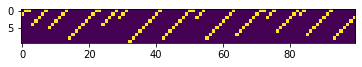

In [370]:
id += 1
plt.imshow(dataset[id].T)

# See if our transformer can learn to reconstruct this dataset

In [371]:
input_seq = torch.swapaxes(dataset, 0, 1).to(torch.float32)
input_seq.shape

torch.Size([100, 200, 10])

In [ ]:
embed_size = 10
heads = 1
dropout = 0.1
forward_expansion = 2

learning_rate = 2e-3
num_epochs = 1000

# model = HollowTransformer(depth=3,
#                           embed_size=embed_size, heads=heads, 
#                           dropout=dropout, forward_expansion=forward_expansion,
#                           offset=True)

model = BiXLNet(seq_len=seq_len, depth=3,
                embed_size=embed_size, heads=heads, 
                dropout=dropout, forward_expansion=forward_expansion)

params = model.parameters()
criterion = torch.nn.MSELoss()  # Adjust based on data type
optimizer = torch.optim.Adam(params, lr=learning_rate)  # Define your params and learning rate

losses = []

pbar = trange(num_epochs)
# Training loop
for epoch in pbar:
    optimizer.zero_grad()
    output = model(input_seq)
    loss = criterion(output, input_seq)
    loss.backward()
    losses.append(loss.detach())
    pbar.set_description("Loss:{:.4f}".format(loss.detach().numpy()))
    optimizer.step()

Loss:0.1033:  14%|█▍        | 140/1000 [00:38<03:34,  4.01it/s]

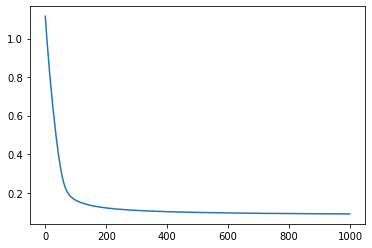

In [362]:
plt.plot(losses)

In [364]:
model.eval()

with torch.no_grad():
    out_seq = model(input_seq)

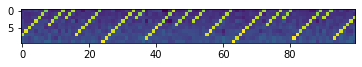

In [365]:
id = 3
plt.imshow((input_seq-out_seq).numpy()[:,id].T)

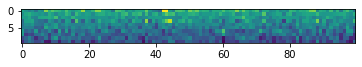

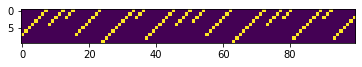

In [366]:
plt.imshow(out_seq.numpy()[:,id].T)
plt.figure()
plt.imshow(input_seq[:,id].T)